# Introduction to Python, Data and the wonderful world of Data Science


In [8]:
# Imports and functions
!pip install -r https://raw.githubusercontent.com/firrm/DAI/main/requirements.txt #ensure we have the right packages
import pandas as pd
import numpy as np
import requests
import tempfile
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio
pio.renderers.default='iframe' # render in the notebook
from scipy.stats import norm
from scipy import stats
import matplotlib.pyplot as plt

def read_hdf_from_url(url):
    """
    Reads an HDF file from a URL since pandas does not support this directly
    """
    response = requests.get(url)
    with tempfile.NamedTemporaryFile() as temp:
        temp.write(response.content)
        return pd.read_hdf(temp.name)

def plot_hist(data, normal=True, **options):
    """
    Plots a histogram of the data along with normal distribution pdf
    """    
    counts, bins = np.histogram(data, range=(data.min(),data.max()), bins=options.pop("bins",100))
    rel = counts / counts.sum() 
    plt.stairs(rel, bins, fill=True, alpha=0.1, **options)

    # Plot the normal distribution
    if normal:
        x = np.linspace(data.min(),data.max())
        y = norm.pdf(x, data.mean(), data.var())
        y *= rel.max()/y.max()
        plt.plot(x, y, alpha=0.8, **options)

    
    

# What is Normal?
(This chapter closely follows the book "Probably overthinking it" by Allen B. Downey, Chp. 1)

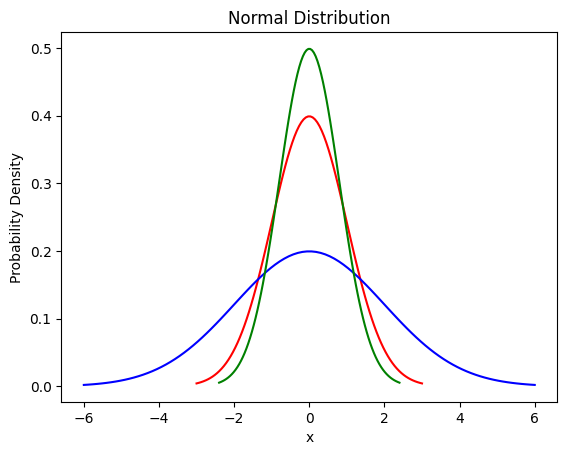

In [2]:
# Define the mean and standard deviation
mu = 0
sigma = 1

# Create a range of x values
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, norm.pdf(x, mu, sigma), color='r', label="N(0,1)")
plt.title('Normal Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')

sigma = 2
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, norm.pdf(x, mu, sigma), color='b', label="N(0,2)")

sigma = 0.8
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, norm.pdf(x, mu, sigma), color='g', label="N(0,0.8)")


# Approaching the normal distribution
It takes time for the central limit theorem to kick in. The more samples we take, the more the distribution of the sample mean will approach a normal distribution.

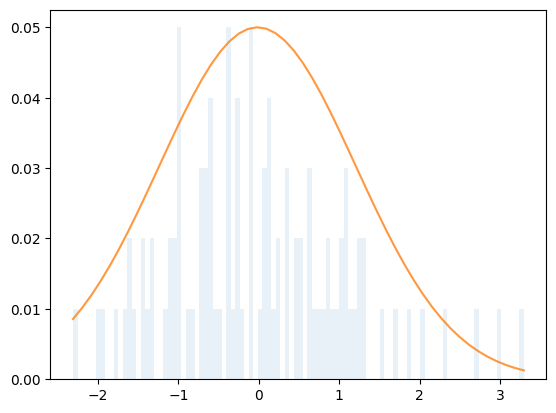

In [3]:
# Normal Distribution
x = np.random.normal(0, 1, 100)
plot_hist(x, normal=True, bins=100)


## So how "normal" can we expect in real life?
Normal means being close to the mean, ie. the expected value of a random variable. But how close? The empirical rule states that for a normal distribution:
- 68% of the data falls within 1 standard deviation of the mean
- 95% of the data falls within 2 standard deviations of the mean
- 99.7% of the data falls within 3 standard deviations of the mean
- 99.99% of the data falls within 4 standard deviations of the mean

Lets look at some real data to see how close we get to this ideal.
Taking info from the [CDC](https://www.cdc.gov/nchs/brfss/index.htm) and [ANSUR](https://www.openlab.psu.edu/ansur2/) datasets.

In [3]:
brfss = read_hdf_from_url("https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/brfss_sample.hdf")
height = brfss.HTM4
height.describe()

count    375271.000000
mean        170.162448
std          10.921335
min          91.000000
25%         163.000000
50%         170.000000
75%         178.000000
max         234.000000
Name: HTM4, dtype: float64

So on average, the height of the people in the dataset is 170.1 cm with a standard deviation of 10.2 cm. Lets see how close the data is to the ideal normal distribution.


In [1]:
px.histogram(height, histnorm='probability', title="Height in cm")

NameError: name 'px' is not defined

In [6]:
# Lets turn that into a distribution
from scipy.stats import rv_histogram
dist = rv_histogram( np.histogram(height.to_list(), range=(height.min(), height.max()), bins=100))
within10 = dist.cdf(height.mean()+10)-dist.cdf(height.mean()-10)
print("To be within 10cm of average height is: {:.2f}%".format(within10*100))
within20 = dist.cdf(height.mean()+20)-dist.cdf(height.mean()-20)
print("To be within 20cm of average height is: {:.2f}%".format(within20*100))
print("To be within the smallest 1% you have to be lower than: {:.2f}cm".format(dist.ppf(0.01)))
print("To be within the tallest 99% you have to be higher than: {:.2f}cm".format(dist.ppf(0.99)))

To be within 10cm of average height is: 61.62%
To be within 20cm of average height is: 95.78%
To be within the smallest 1% you have to be lower than: 149.69cm
To be within the tallest 99% you have to be higher than: 193.72cm


But of course you will say that's much different for females and males and thats true. 

In [7]:
brfss["HTM4"].groupby(brfss["_SEX"]).describe()

,count,mean,std,min,25%,50%,75%,max
_SEX,,,,,,,,
1,184402.0,177.492137,8.554170,91.0,173.0,178.0,183.0,234.0
2,190869.0,163.081103,7.859125,91.0,157.0,163.0,168.0,218.0


You can easily repeat this for the subgroups, but more importantly the distribution is not that much away from normal. But how about when we include many more variables like in the ANSUR dataset?

In [11]:
ansur_male = pd.read_csv("http://tools.openlab.psu.edu/publicData/ANSUR_II_MALE_Public.csv", encoding="ISO-8859-1")
ansur_female =  pd.read_csv("http://tools.openlab.psu.edu/publicData/ANSUR_II_FEMALE_Public.csv", encoding="ISO-8859-1")
ansur = pd.concat([ansur_female,ansur_male])
ansur.head()

,SubjectId,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,...,PrimaryMOS,SubjectsBirthLocation,SubjectNumericRace,Ethnicity,DODRace,Age,Heightin,Weightlbs,WritingPreference,subjectid
0,10037.0,231,1282,301,204,1180,222,177,373,315,...,92Y,Germany,2,NaN,2,26,61,142,Right hand,NaN
1,10038.0,194,1379,320,207,1292,225,178,372,272,...,25U,California,3,Mexican,3,21,64,120,Right hand,NaN
2,10042.0,183,1369,329,233,1271,237,196,397,300,...,35D,Texas,1,NaN,1,23,68,147,Right hand,NaN
3,10043.0,261,1356,306,214,1250,240,188,384,364,...,25U,District of Columbia,8,Caribbean Islander,2,22,66,175,Right hand,NaN
4,10051.0,309,1303,308,214,1210,217,182,378,320,...,42A,Texas,1,NaN,1,45,63,195,Right hand,NaN


In [13]:
ansur["stature"]=ansur["stature"]/10 # convert to cm
ansur.groupby("Gender")["stature"].describe()


,count,mean,std,min,25%,50%,75%,max
Gender,,,,,,,,
Female,1986.0,16.284733,0.641995,14.09,15.8625,16.26,16.72,18.29
Male,4082.0,17.562146,0.685508,14.91,17.1000,17.55,18.02,19.93


In [15]:
fig = px.histogram(ansur, x="stature", color="Gender", marginal="box", title="Height in cm")
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.75)
fig.show()

# But why?
Consider the following - biologcially very crude - model of height:
- Height is determined by many factors such as genes and environment
- These factors are additive
- In a random invidual these factors are random

We can illustrate this point with the following simple simulation 


In [22]:
def run_simulation(series, num_effects=20, effect_range=(-3, 3)):
    """
    Rewriten from AllenDowney's Probably Overthinking it book
    Simulate the sum of randomly-selected effects.

    Args:
        series (pandas.Series): Input series to match the mean and standard deviation.
        num_effects (int, optional): Number of effects to generate. Defaults to 20.
        effect_range (tuple, optional): Range of the uniform distribution for generating effects. Defaults to (-3, 3).

    Returns:
        pandas.Series: Series of simulated values.
    """
    effects = np.random.uniform(*effect_range, size=(2, num_effects))
    flips = np.random.choice([True, False], size=(len(series), num_effects))
    totals = np.where(flips, effects[0], effects[1]).sum(axis=1)

    sim = (totals - totals.mean()) / totals.std() * series.std() + series.mean()
    return sim

np.random.seed(42)
sim_female = run_simulation(ansur[ansur["Gender"]=="Female"]["stature"])
sim_male = run_simulation(ansur[ansur["Gender"]=="Male"]["stature"])

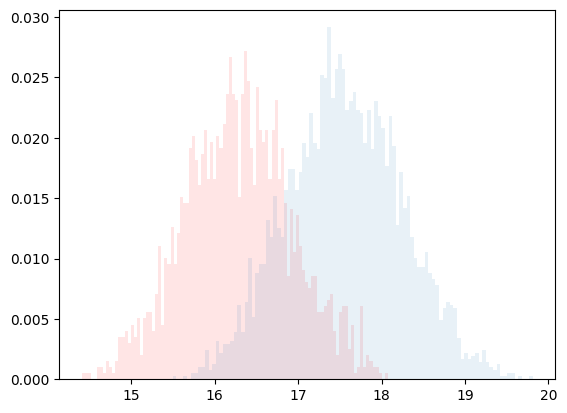

In [23]:
plot_hist(sim_female, normal=False, color="r")
plot_hist(sim_male, normal=False)


## Takeaway: Sufficient **additive** effects lead to normal distributions, ie. central limit theorem
## Takeaway: Simulating the data-generating process helps to understand the causality of the sample

# So what about the *combination* of several variables? Or how normal are we?
The ANSUR database contains a lot of measurements of the human body. The original goal of the US army was to find the best fit for equipement, eg pilot cockpits, gear etc. Lets see how normal the distribution of these measurements are.

<img src="https://www.openlab.psu.edu/files/2018/02/ansur2banner-2o4jcnh.jpg">

In [24]:
measurements = [column for column in ansur.columns if column.lower() == column]
measurements

['abdominalextensiondepthsitting',
 'acromialheight',
 'acromionradialelength',
 'anklecircumference',
 'axillaheight',
 'balloffootcircumference',
 'balloffootlength',
 'biacromialbreadth',
 'bicepscircumferenceflexed',
 'bicristalbreadth',
 'bideltoidbreadth',
 'bimalleolarbreadth',
 'bitragionchinarc',
 'bitragionsubmandibulararc',
 'bizygomaticbreadth',
 'buttockcircumference',
 'buttockdepth',
 'buttockheight',
 'buttockkneelength',
 'buttockpopliteallength',
 'calfcircumference',
 'cervicaleheight',
 'chestbreadth',
 'chestcircumference',
 'chestdepth',
 'chestheight',
 'crotchheight',
 'crotchlengthomphalion',
 'crotchlengthposterioromphalion',
 'earbreadth',
 'earlength',
 'earprotrusion',
 'elbowrestheight',
 'eyeheightsitting',
 'footbreadthhorizontal',
 'footlength',
 'forearmcenterofgriplength',
 'forearmcircumferenceflexed',
 'forearmforearmbreadth',
 'forearmhandlength',
 'functionalleglength',
 'handbreadth',
 'handcircumference',
 'handlength',
 'headbreadth',
 'headcir

## How to measure distance to normal distribution?
Kolmorogov-Smirnov test: The Kolmogorov-Smirnov test is a non-parametric test that compares the distribution of a sample to a reference probability distribution. The test is based on the maximum difference between the cumulative distribution functions of the sample and the reference distribution. [Wikipedia](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test)
Using the scipy library we can easily perform this test using [stats.kstest](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kstest.html#scipy.stats.kstest), it will return the KS-Distance and the p-value.
Our null hypothesis is that the sample is drawn from the reference distribution, ie. the normal distribution with mean and std of the sample. We reject the null hypothesis if the p-value is below a certain threshold, eg. 0.05. 


In [25]:
# Let us loop a bit
threshold = 0.05
results = [] # store the results
for g in ["Female", "Male"]: #Loop over the genders
    res = [] # store the results for each measurement
    for m in measurements: # Loop over the measurements
        series = ansur[ansur["Gender"]==g][m] # Get the series
        gaussian_dist = stats.norm(loc=series.mean(), scale=series.std()) # Create a normal distribution with the appropriate mean and std
        res.append(stats.kstest(series, gaussian_dist.cdf)[1]) # Store the result for the measurement m, returns the KS distance [0] and the p-value [1]
    results.append(pd.Series(res, index=measurements, name=g)) # Store the full results

result_df = pd.concat(results, axis=1) # Make a nice df
result_df["Reject H0_Female"] = result_df["Female"]  < threshold # Add a column with the result
result_df["Reject H0_Male"] = result_df["Male"]  < threshold # Add a column with the result
result_df


,Female,Male,Reject H0_Female,Reject H0_Male
abdominalextensiondepthsitting,4.170113e-05,9.518955e-09,True,True
acromialheight,4.523367e-02,3.363591e-01,True,False
acromionradialelength,7.628389e-02,1.904977e-02,False,True
anklecircumference,1.728475e-04,1.993547e-07,True,True
axillaheight,8.877286e-02,2.279965e-01,False,False
...,...,...,...,...
waistheightomphalion,9.301357e-02,2.759734e-01,False,False
weightkg,6.276133e-04,9.507739e-05,True,True
wristcircumference,9.564989e-07,6.985675e-05,True,True
wristheight,2.865084e-01,3.482659e-01,False,False


## The average Men (or Woman)


In [33]:
# The average Men (or Women)
gender = "Male"
num_std = 0.3 # How many standard deviations are we considering to be average

res = []

for varname in [
    "stature",
    "chestcircumference",
    "sleevelengthspinewrist",
    "crotchheight",
    "verticaltrunkcircumferenceusa",
    "hipbreadthsitting",
    "neckcircumference",
    "waistcircumference",
    "thighcircumference",
    "crotchlengthposterioromphalion",
]:
    series = ansur[ansur["Gender"]==gender][varname] / 10 # convert to cm
    if varname == "stature": series *= 10 # convert back ;-)
    low, high = np.array([-num_std, num_std]) * series.std() + series.mean()
    nearly_average = series.between(low, high)
    frac = nearly_average.mean() * 100
    res.append((varname, series.mean(), series.std(), low, high, frac))

columns = ["Measurement", "Mean", "Std Dev", "Low", "High", "% in range"]
index = [
    "Stature (height)",
    "Chest Circumference",
    "Sleeve Length",
    "Crotch Height",
    "Vertical Trunk Circ.",
    "Hip Breadth Sitting",
    "Neck Circumference",
    "Waist Circumference",
    "Thigh Circumference",
    "Crotch Length",
]
table = pd.DataFrame(res, columns=columns, index=index)
table.index.name = "Measurement"
table

,Measurement,Mean,Std Dev,Low,High,% in range
Measurement,,,,,,
Stature (height),stature,17.562146,0.685508,17.356494,17.767798,23.248408
Chest Circumference,chestcircumference,105.870554,8.743527,103.247495,108.493612,22.929936
Sleeve Length,sleevelengthspinewrist,89.584713,4.022022,88.378107,90.791320,23.052425
Crotch Height,crotchheight,84.592994,4.649916,83.198019,85.987968,22.146007
Vertical Trunk Circ.,verticaltrunkcircumferenceusa,166.480426,8.952842,163.794574,169.166279,24.228319
Hip Breadth Sitting,hipbreadthsitting,37.929740,3.020522,37.023584,38.835897,24.767271
Neck Circumference,neckcircumference,39.764895,2.577676,38.991592,40.538198,25.208231
Waist Circumference,waistcircumference,94.057741,11.170587,90.706565,97.408918,22.072513
Thigh Circumference,thighcircumference,62.514233,5.845217,60.760668,64.267798,24.889760


In [31]:
average_table = pd.DataFrame(index=ansur.index, dtype=bool)

for measurement, row in table.iterrows():
    varname, _, _, low, high, _ = row
    average_table[varname] = ansur_male[varname].between(low * 10, high * 10)

average_table.head()

,stature,chestcircumference,sleevelengthspinewrist,crotchheight,verticaltrunkcircumferenceusa,hipbreadthsitting,neckcircumference,waistcircumference,thighcircumference,crotchlengthposterioromphalion
0,False,True,False,False,False,False,True,True,True,True
1,False,False,False,True,False,False,False,False,False,False
2,False,False,False,True,True,False,True,True,False,True
3,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,True,True,True,False,False,False


In [32]:
cumulative_table = pd.DataFrame(
    np.cumprod(average_table.values, axis=1), 
    index=average_table.index, columns=average_table.columns, dtype=bool
)

cumulative_table.sum()

stature                           0
chestcircumference                0
sleevelengthspinewrist            0
crotchheight                      0
verticaltrunkcircumferenceusa     0
hipbreadthsitting                 0
neckcircumference                 0
waistcircumference                0
thighcircumference                0
crotchlengthposterioromphalion    0
dtype: int64

# So nobody is average in these measures....
Lesson learned here is that if you have many variables, the probability of being average in all of them is very low. This is a consequence of the central limit theorem.

# But what about non-normal measurements?
Looking at the BRFSS Data we see quite long tails for the weight. 

In [35]:
px.histogram(brfss, x= "WTKG3", color="_SEX", histnorm='probability', title="Weight in kg")


However looking at birth weights we see a different picture, here the distribution is more normal, cf. NSFG.

In [36]:
nsfg = read_hdf_from_url("https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/data/nsfg_sample.hdf5")
nsfg.drop(nsfg[nsfg["babysex1"] == 9].index, inplace=True) # Drop unknown
nsfg.drop(nsfg[nsfg["outcome"] != 1].index, inplace=True) # Drop non-live births
nsfg.drop(nsfg[nsfg["nbrnaliv"] != 1].index, inplace=True) # Drop non-single births
nsfg.drop(nsfg[nsfg["prglngth"] < 37].index, inplace=True) # Drop preterm births
nsfg.drop(nsfg[nsfg["prglngth"] > 41].index, inplace=True) # Drop postterm births
nsfg["birthweight"] = ((nsfg["birthwgt_lb1"].replace([98,99], np.nan)) + nsfg["birthwgt_oz1"].replace([98,99], np.nan)/16)*454
px.histogram(nsfg, x= "birthweight", color="babysex1", histnorm='probability', title="Weight in kg")


 So what happens after birth? Let's simulate.

In [37]:
birthweight = nsfg["birthweight"] /1000 # convert to kg
np.random.seed(18)
factors = np.random.uniform(-3,3, size=(len(birthweight), 40)) * 0.03 + 1.3
#factors = np.random.normal(loc=1.3, scale=0.03, size=(len(birthweight), 60))
sim_weight = birthweight * np.prod(factors, axis=1)
px.histogram(sim_weight, histnorm='probability', title="Weight in kg")

# Takeaway: Multiplikative effects lead to **log-normal** distributions (correlary to CLT)

# Data Bias
Data bias is a type of error that results from a systematic distortion of a sample or population of data. The bias can result from the way the data is collected, the way it is analysed, or the way it is presented. [Wikipedia](https://en.wikipedia.org/wiki/Data_bias)
Sometimes we have biased data, eg. when we sample from a population with different probabilities. This can lead to a biased sample. We can correct for this by reweighting the data.
Sometimes we choose to exclude data, like in the birthweight example above. In any case we need to **know** what is going on... so let's look at biases in data.

In [41]:
# Example data from [Purdue University](https://web.archive.org/web/20160415011613/https://www.purdue.edu/datadigest/2013-14/InstrStuLIfe/DistUGClasses.html)
sizes = [(1, 1), (2, 9), (10, 19), (20, 29), (30, 39), (40, 49), (50, 99), (100, 300)] # Read Class size #0 with 1 student, clas size #1 2-9 students etc.
counts = [138, 635, 1788, 1979, 796, 354, 487, 333] # Count of classes in each size

# Create a dataframe
t=[]
for (low,high), count in zip(sizes,counts):
    print("[{0},{1}] = {2}".format(low, high, count ))
    sample = np.random.randint(low, high+1, count)
    t.extend(sample)
unbiased_sample = np.array(t)

[1,1] = 138
[2,9] = 635
[10,19] = 1788
[20,29] = 1979
[30,39] = 796
[40,49] = 354
[50,99] = 487
[100,300] = 333


## But what if the data is biased? We simple re-weight the unbiased data with the counts


In [42]:
biased_sample = np.random.choice(unbiased_sample, size=unbiased_sample.size, p=unbiased_sample/np.sum(unbiased_sample))
ff.create_distplot([unbiased_sample,biased_sample], group_labels=["Unbiased","Biased"], bin_size=1, show_rug=False, show_hist=False)


In [43]:
print("Unbiased mean: {:.2f}, Biased mean: {:.2f}".format(unbiased_sample.mean(), biased_sample.mean()))


Unbiased mean: 34.42, Biased mean: 91.01


## How to unbias the data?
Consider a random sample of 500 class sizes from the biased data. We can use the inverse of the weights to unbias the data.

In [44]:
# Lets do the reverse, Unbiased the biased data
sample = np.random.choice(biased_sample, 500)
inverse_weight = 1/sample
reweighted_sample = np.random.choice(sample, size=sample.size, p=inverse_weight/inverse_weight.sum())
ff.create_distplot([reweighted_sample,sample], group_labels=["Unbiased","Biased"], bin_size=1, show_rug=False, show_hist=False)


# Are you popular? A more complex example of bias
[Stanford Network Analysis Data](http://snap.stanford.edu/data/egonets-Facebook.html) for 4000 Facebook users.

In [54]:
import networkx as nx
facebook = pd.read_csv("https://snap.stanford.edu/data/facebook_combined.txt.gz", sep=" ", header=None)
fb = nx.Graph() #new empty graph
fb.add_edges_from(facebook.values) # add edges from the dataframe

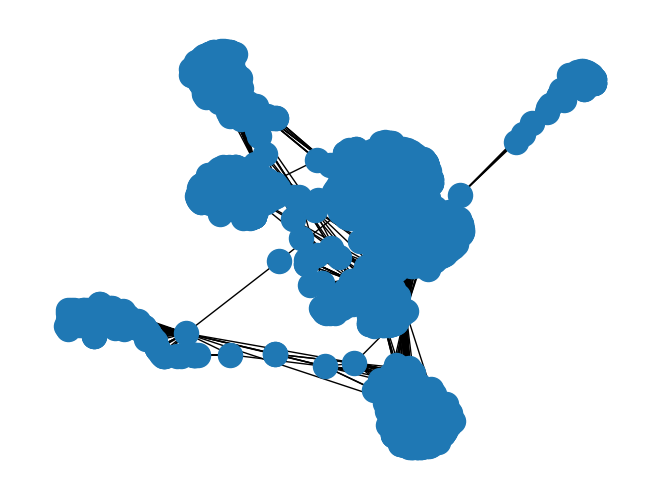

In [32]:
nx.draw_spring(fb)

In [55]:
unbiased = [fb.degree(node) for node in fb] # Get the degree of each node, ie. the number of friends
biased = np.random.choice(unbiased, size=len(unbiased), p=unbiased/np.sum(unbiased)) # calculate the biased sample
#zooming in
biased = [x for x in biased if x <= 250]
unbiased = [x for x in unbiased if x <= 250]
#plotting
ff.create_distplot([biased, unbiased], group_labels=["Friends","People"], bin_size=1, show_rug=False, show_hist=False)


In [56]:
import statistics # since we have lists hereimport networkx as nx
print("Average number of friends: {:.2f} (biased), {:.2f} (unbiased)".format(statistics.mean(biased), statistics.mean(unbiased)))


Average number of friends: 91.00 (biased), 42.70 (unbiased)


# Takeaway: Bias is a systematic error that can be corrected by reweighting the data

# Summary
- The data generating process is the key to understanding the distribution of the data.
-- Additive effects lead to normal distributions
-- Multiplicative effects (proportional growth) lead to log-normal distributions
- Sampling biases are a common source of error in data and can be corrected by reweighting the data